## Addestramento EfficientNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import os
from tqdm import tqdm
from PIL import Image


# Definizione del dataset personalizzato per gli spettrogrammi
class SpectrogramDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.class_to_idx = {}

        # Carica i dati e le etichette
        for class_idx, class_name in enumerate(sorted(os.listdir(data_dir))):
            class_dir = os.path.join(data_dir, class_name)
            if os.path.isdir(class_dir):
                self.class_to_idx[class_name] = class_idx
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.data.append(img_path)
                        self.labels.append(class_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]

        # Carica l'immagine
        image = Image.open(img_path).convert('RGB')

        # Applica le trasformazioni se specificate
        if self.transform:
            image = self.transform(image)

        return image, label


# Iperparametri
num_epochs = 25
batch_size = 32
learning_rate = 0.001
patience = 5
num_classes = 5  # Modifica in base al tuo dataset
data_path = "Alfabeto1_Multiclasse_NoAug"

# Preparazione del dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = SpectrogramDataset(os.path.join(data_path, 'train'), transform=transform)
val_dataset = SpectrogramDataset(os.path.join(data_path, 'val'), transform=transform)

print(f"Numero di campioni nel training set: {len(train_dataset)}")
print(f"Numero di campioni nel validation set: {len(val_dataset)}")

if len(train_dataset) == 0 or len(val_dataset) == 0:
    raise ValueError("Uno o entrambi i dataset sono vuoti. Verifica i percorsi dei dati.")

num_classes = len(train_dataset.class_to_idx)
print(f"Numero di classi: {num_classes}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Carica il modello EfficientNet pre-addestrato
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Funzione per calcolare le metriche
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return precision, recall, f1


# Inizializzazione delle variabili per il salvataggio
best_f1 = 0
best_epoch = 0
epochs_no_improve = 0
metrics = []

# Ciclo di addestramento
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_pred = []
    train_true = []

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_pred.extend(predicted.cpu().numpy())
        train_true.extend(labels.cpu().numpy())

    train_loss /= len(train_loader)
    train_precision, train_recall, train_f1 = calculate_metrics(train_true, train_pred)

    # Validazione
    model.eval()
    val_loss = 0
    val_pred = []
    val_true = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_pred.extend(predicted.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_precision, val_recall, val_f1 = calculate_metrics(val_true, val_pred)

    # Salvataggio dei pesi dell'epoca corrente
    torch.save(model.state_dict(), f'model_epoch_{epoch + 1}.pth')

    # Aggiornamento del miglior modello
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve == patience:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break

    # Salvataggio delle metriche
    metrics.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'val_loss': val_loss,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
    })

# Salvataggio delle metriche in un file CSV
pd.DataFrame(metrics).to_csv('training_metrics.csv', index=False)

print(f"Addestramento completato. Miglior epoca: {best_epoch + 1}")

## Testing EfficientNet

Directory exists: DatasetMulticlass
Directory exists: DatasetMulticlass\test
Number of classes: 5
Nessun peso salvato trovato. Assicurati di avere il file dei pesi salvato in C:\Users\ddefs\Documents\University\FVAB - Nappi\Project\EfficientNet_Multiclasse_NoAug\best_model.pth


C:\Users\ddefs\Documents\University\FVAB - Nappi\Project\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ddefs\Documents\University\FVAB - Nappi\Project\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Loss: 1.6097 Acc: 0.2338 F1: 0.0886 Precision: 0.8208 Recall: 0.2338


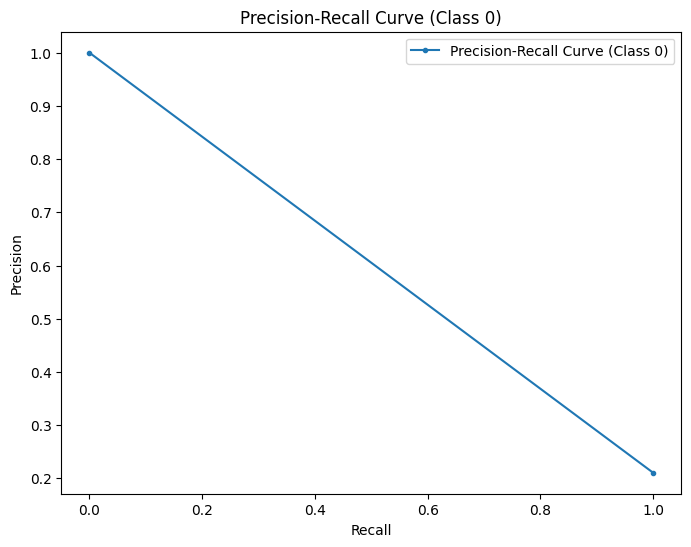

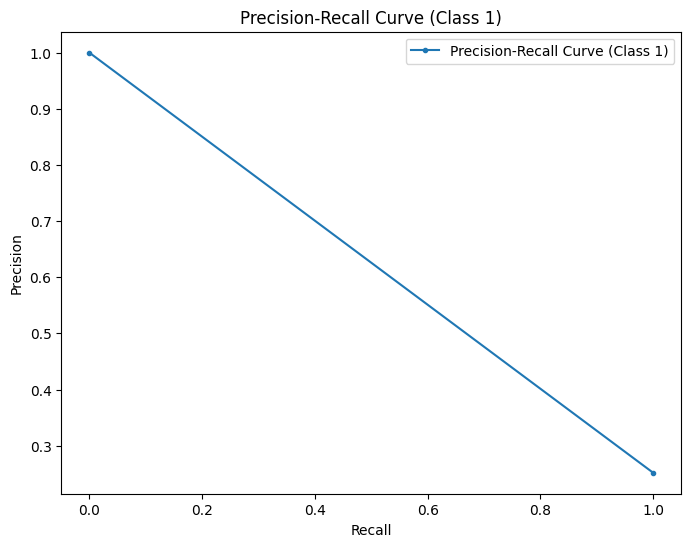

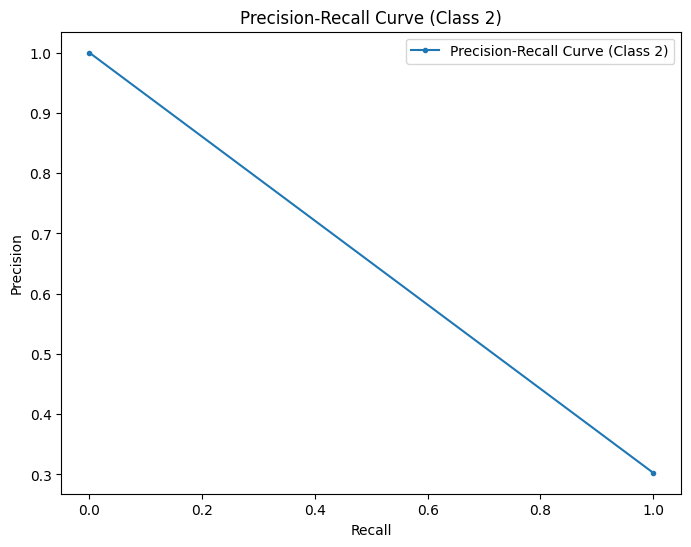

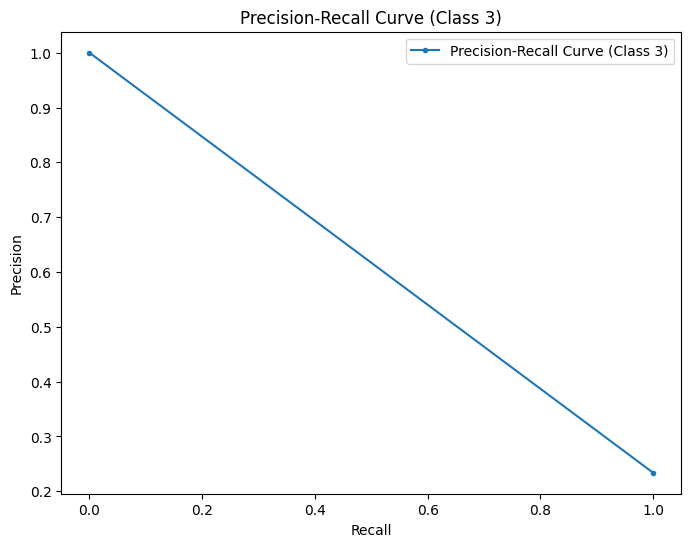

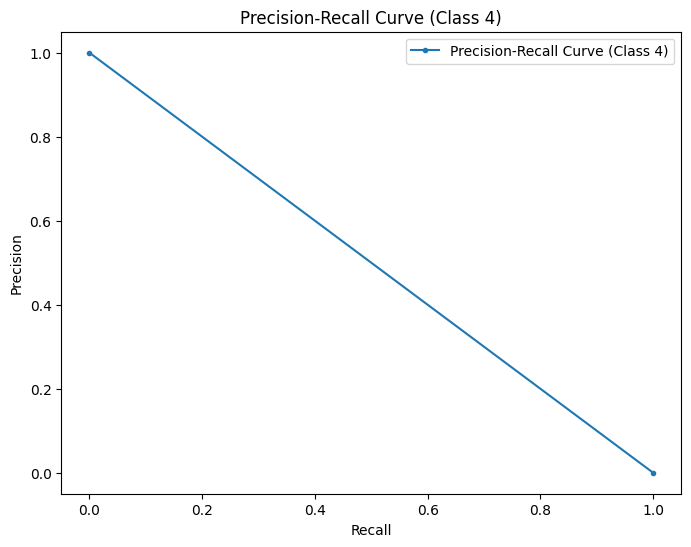

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import UnidentifiedImageError
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
import csv
import matplotlib.pyplot as plt
import numpy as np

# Configurazione dei percorsi
dataset_dir = 'DatasetMulticlass'  
weights_path = 'EfficientNet_Multiclasse_NoAug/best_model.pth'
metrics_path = 'EfficientNet_Multiclasse_NoAug/training_metrics.csv'
results_path = 'testing/EfficientNet_Multiclass_NoBil.csv'

# Verifica se il percorso del dataset è corretto
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Directory not found: {dataset_dir}")
else:
    print(f"Directory exists: {dataset_dir}")

# Trasformazioni
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Funzione di filtro per i file validi
def is_valid_file(file_path):
    valid_extensions = ['.png', '.jpg', '.jpeg']
    return any(file_path.lower().endswith(ext) for ext in valid_extensions) and '.ipynb_checkpoints' not in file_path

# Funzione per caricare il dataset
def load_dataset(phase):
    dataset_path = os.path.join(dataset_dir, phase)
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Directory not found: {dataset_path}")
    return datasets.ImageFolder(dataset_path, transform=data_transforms[phase], is_valid_file=is_valid_file)

# Funzione di test
def test_model(model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []
    all_probs = []

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Probabilità per ogni classe
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']
    test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} F1: {test_f1:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f}')

    return test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs

# Funzione per salvare i risultati del test
def save_test_results(global_metrics, per_class_metrics, results_path):
    with open(results_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Test Loss', 'Test Accuracy', 'Test F1', 'Test Precision', 'Test Recall'])
        writer.writerow(global_metrics)
        writer.writerow(['Class', 'Best Threshold', 'Precision', 'Recall', 'F1'])
        writer.writerows(per_class_metrics)

# Caricamento del modello e impostazioni
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(pretrained=False)
num_ftrs = model.classifier[1].in_features

# Determina il numero di classi nel dataset di test
test_dir = os.path.join(dataset_dir, 'test')
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Directory not found: {test_dir}")
else:
    print(f"Directory exists: {test_dir}")

class_folders = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
num_classes = len(class_folders)
print(f"Number of classes: {num_classes}")

# Modifica il livello finale del modello
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Carica i pesi del modello tranne l'ultimo livello
absolute_weights_path = os.path.abspath(weights_path)
if os.path.exists(absolute_weights_path):
    print(f"Caricamento dei pesi salvati da {absolute_weights_path}")
    state_dict = torch.load(absolute_weights_path, map_location=torch.device('cpu'))
    state_dict['classifier.1.weight'] = model.classifier[1].weight
    state_dict['classifier.1.bias'] = model.classifier[1].bias
    model.load_state_dict(state_dict, strict=False)
else:
    print(f"Nessun peso salvato trovato. Assicurati di avere il file dei pesi salvato in {absolute_weights_path}")

criterion = nn.CrossEntropyLoss()

# Caricamento del dataset di test con gestione delle eccezioni
def load_dataset_with_error_handling(phase):
    dataset_path = os.path.join(dataset_dir, phase)
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Directory not found: {dataset_path}")

    dataset = datasets.ImageFolder(dataset_path, transform=data_transforms[phase], is_valid_file=is_valid_file)

    valid_samples = []
    for path, target in dataset.samples:
        try:
            dataset.loader(path)  # Try to load the image to ensure it's valid
            valid_samples.append((path, target))
        except UnidentifiedImageError:
            print(f"UnidentifiedImageError: {path}")

    dataset.samples = valid_samples
    return dataset

test_dataset = load_dataset_with_error_handling('test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# Aggiorna i dizionari
image_datasets = {'test': test_dataset}
dataloaders = {'test': test_loader}
dataset_sizes = {'test': len(test_dataset)}

# Esegui il test del modello
test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs = test_model(model, criterion)

# Converti all_probs in un array NumPy
all_probs = np.array(all_probs)

# Salva le metriche globali
global_metrics = [test_loss, test_acc.item(), test_f1, test_precision, test_recall]

# Calcola la curva Precision-Recall e la soglia ottimale per ogni classe
thresholds_and_metrics = []
for i in range(num_classes):
    precisions, recalls, thresholds = precision_recall_curve([1 if label == i else 0 for label in all_labels], all_probs[:, i])
    
    # Calcola F1 scores evitando divisione per zero
    f1_scores = np.divide(2 * (precisions * recalls), (precisions + recalls), out=np.zeros_like(precisions), where=(precisions + recalls) != 0)
    
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index] if best_index < len(thresholds) else 1.0
    best_precision = precisions[best_index]
    best_recall = recalls[best_index]
    best_f1 = f1_scores[best_index]
    
    thresholds_and_metrics.append([i, best_threshold, best_precision, best_recall, best_f1])
    
    # Visualizzazione della curva Precision-Recall per ogni classe
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='.', label=f'Precision-Recall Curve (Class {i})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (Class {i})')
    plt.legend()
    plt.show()

# Salva i risultati del test inclusa la soglia e le metriche relative per ogni classe
save_test_results(global_metrics, thresholds_and_metrics, results_path)
